In [1]:
from PIL import Image
import torch
import torchvision
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os
import pickle

In [16]:
class Dataset():
    def __init__(self):
        self.labels,self.images = self.load_data()

    # To load images and labels for dataloader
    def load_data(self):
        labels={}
        images = {}
        count = 0
        # setting resize dimensions
        resize = transforms.Compose([transforms.Resize((256,256))])
        main_dir = os.listdir(os.path.join("C:\JITHIN\Projects\AI & ML\Plant Disease Detection\dataset\dataset","C:\JITHIN\Projects\AI & ML\Plant Disease Detection\dataset\dataset/train"))
        reference = {}
        # iterating through categories
        for i,dir in enumerate(main_dir):
            reference[dir]=i
            images_list = os.listdir(os.path.join("C:\JITHIN\Projects\AI & ML\Plant Disease Detection\dataset\dataset","C:\JITHIN\Projects\AI & ML\Plant Disease Detection\dataset\dataset/train",dir))
            local_cnt = 0
            # iterating through images in a category
            for img in images_list:
                # 500 images from each category
                if local_cnt<500:
                    labels[count] = i
                    img_path = os.path.join("C:\JITHIN\Projects\AI & ML\Plant Disease Detection\dataset\dataset","C:\JITHIN\Projects\AI & ML\Plant Disease Detection\dataset\dataset/train",dir,img)
                    image = Image.open(img_path)
                    image = ToTensor()(image)
                    images[count] = resize(image)
                    count+=1
                    local_cnt+=1
                else:
                    break

        print(reference)
        return labels,images

    def __len__(self):
        return len(self.labels)


    # To return x,y values in each iteration over dataloader as batches.
    def __getitem__(self, idx):
        return (
            self.images[idx],
            self.labels[idx],
        )

In [18]:
# Inherit from Dataset class
class ValDataset(Dataset):

    def load_data(self):
          labels={}
          images = {}
          count = 0
          resize = transforms.Compose([transforms.Resize((256,256))])
          main_dir = os.listdir(os.path.join("C:\JITHIN\Projects\AI & ML\Plant Disease Detection\dataset\dataset","C:\JITHIN\Projects\AI & ML\Plant Disease Detection\dataset\dataset/valid"))
          for i,dir in enumerate(main_dir):
              print(i,dir)
              images_list = os.listdir(os.path.join("C:\JITHIN\Projects\AI & ML\Plant Disease Detection\dataset\dataset","C:\JITHIN\Projects\AI & ML\Plant Disease Detection\dataset\dataset/valid",dir))
              local_cnt = 0
              for img in images_list:
                  if(local_cnt<100):
                      labels[count] = i
                      img_path = os.path.join("C:\JITHIN\Projects\AI & ML\Plant Disease Detection\dataset\dataset","C:\JITHIN\Projects\AI & ML\Plant Disease Detection\dataset\dataset/valid",dir,img)
                      image = Image.open(img_path)
                      image = ToTensor()(image)
                      images[count] = resize(image)
                      count+=1
                      local_cnt+=1
                  else:
                      break

          return labels,images


In [4]:
# Model Architecture
class Network(nn.Module):
    def __init__(self):
        super(Network,self).__init__()

        # CNNs for rgb images
        self.conv1= nn.Conv2d(in_channels=3,out_channels=6,kernel_size=5)
        self.conv2= nn.Conv2d(in_channels=6,out_channels=12,kernel_size=5)
        self.conv3= nn.Conv2d(in_channels=12,out_channels=24,kernel_size=5)
        self.conv4= nn.Conv2d(in_channels=24,out_channels=48,kernel_size=5)

        # Connecting CNN outputs with Fully Connected layers
        self.fc1 = nn.Linear(in_features=48*12*12,out_features=240)
        self.fc2 = nn.Linear(in_features=240,out_features=120)
        self.out = nn.Linear(in_features=120,out_features=17)


    def forward(self,t):
        t = t

        t=self.conv1(t)
        t=F.relu(t)
        t=F.max_pool2d(t,kernel_size = 2, stride = 2)


        t=self.conv2(t)
        t=F.relu(t)
        t=F.max_pool2d(t,kernel_size = 2, stride = 2)

        t=self.conv3(t)
        t=F.relu(t)
        t=F.max_pool2d(t,kernel_size = 2, stride = 2)

        t=self.conv4(t)
        t=F.relu(t)
        t=F.max_pool2d(t,kernel_size = 2, stride = 2)

        t=t.reshape(-1,48*12*12)
        t=self.fc1(t)
        t=F.relu(t)


        t=self.fc2(t)
        t=F.relu(t)

        t=self.out(t)


        return t

In [5]:
model = Network()

In [17]:
dataset = Dataset()

{'Cherry___healthy': 0, 'Cherry___Powdery_mildew': 1, 'Pepper___Bacterial_spot': 2, 'Pepper___healthy': 3, 'Potato___Early_blight': 4, 'Potato___healthy': 5, 'Potato___Late_blight': 6, 'Tomato___Bacterial_spot': 7, 'Tomato___Early_blight': 8, 'Tomato___healthy': 9, 'Tomato___Late_blight': 10, 'Tomato___Leaf_Mold': 11, 'Tomato___Septoria_leaf_spot': 12, 'Tomato___Spider_mites Two-spotted_spider_mite': 13, 'Tomato___Target_Spot': 14, 'Tomato___Tomato_mosaic_virus': 15, 'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 16}


In [19]:
valdataset = ValDataset()

0 Cherry___healthy
1 Cherry___Powdery_mildew
2 Pepper___Bacterial_spot
3 Pepper___healthy
4 Potato___Early_blight
5 Potato___healthy
6 Potato___Late_blight
7 Tomato___Bacterial_spot
8 Tomato___Early_blight
9 Tomato___healthy
10 Tomato___Late_blight
11 Tomato___Leaf_Mold
12 Tomato___Septoria_leaf_spot
13 Tomato___Spider_mites Two-spotted_spider_mite
14 Tomato___Target_Spot
15 Tomato___Tomato_mosaic_virus
16 Tomato___Tomato_Yellow_Leaf_Curl_Virus


In [20]:
# Function to return number of correct predictions in a batch
def get_num_correct(preds,labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

In [21]:
def train(dataset,valdataset, model):
    model.train()

    # dataloader in pytorch to load validation and train dataset
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=64,shuffle=True)
    valdataloader = torch.utils.data.DataLoader(valdataset, batch_size=32,shuffle=True)

    # Defining the loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    num_of_epochs = 20
    epochs = []
    losses = []
    for epoch in range(num_of_epochs):
        cnt = 0
        tot_loss = 0
        tot_correct = 0
        for batch, (x, y) in enumerate(dataloader):
            # Sets the gradients of all optimized tensors to zero
            optimizer.zero_grad()
            y_pred = model(x)
            # Compute loss (here CrossEntropyLoss)
            loss = F.cross_entropy(y_pred,y)

            loss.backward()
            optimizer.step()

        for batch, (x, y) in enumerate(valdataloader):
            # Sets the gradients of all optimized tensors to zero
            optimizer.zero_grad()
            with torch.no_grad():
                y_pred = model(x)
                # Compute loss (here CrossEntropyLoss)
                loss = F.cross_entropy(y_pred,y)

            tot_loss+=loss.item()
            tot_correct +=get_num_correct(y_pred,y)
        epochs.append(epoch)
        losses.append(tot_loss)
        print("Epoch",epoch,"total_correct",tot_correct,"loss:",tot_loss)
        torch.save(model.state_dict(), "model002_ep"+str(epoch+1)+".pth")

    # Plot a Validation Loss vs Epochs graph
    plt.plot(epochs, losses, color='green', linewidth = 3,
         marker='o', markerfacecolor='blue', markersize=8)
    plt.xlabel('epochs ---->',color='m',fontsize='xx-large' )
    plt.ylabel('loss ------>',color='m',fontsize='xx-large')
    axes = plt.gca()        # 'gca' - get current axes
    axes.set_facecolor('c') #'c' - cyan
    axes.tick_params(axis='y', which='both', colors='tomato')
    axes.tick_params(axis='x', which='both', colors='#20ff14')
    plt.title("Val Loss vs Epoch",color='m',fontsize='xx-large')

Epoch 0 total_correct 14 loss: 16.920907974243164
Epoch 1 total_correct 18 loss: 16.217175006866455
Epoch 2 total_correct 18 loss: 16.06912589073181
Epoch 3 total_correct 35 loss: 14.31462574005127
Epoch 4 total_correct 40 loss: 13.610269784927368
Epoch 5 total_correct 38 loss: 13.02198326587677
Epoch 6 total_correct 34 loss: 13.783411026000977
Epoch 7 total_correct 35 loss: 14.072865962982178
Epoch 8 total_correct 46 loss: 12.503559827804565
Epoch 9 total_correct 50 loss: 12.917550086975098
Epoch 10 total_correct 50 loss: 12.209159255027771
Epoch 11 total_correct 53 loss: 12.769194483757019
Epoch 12 total_correct 63 loss: 11.247921466827393
Epoch 13 total_correct 61 loss: 12.370785236358643
Epoch 14 total_correct 62 loss: 11.618637800216675
Epoch 15 total_correct 61 loss: 11.643311023712158
Epoch 16 total_correct 46 loss: 14.168717503547668
Epoch 17 total_correct 66 loss: 11.211166024208069
Epoch 18 total_correct 69 loss: 12.84859013557434
Epoch 19 total_correct 75 loss: 11.4804593324

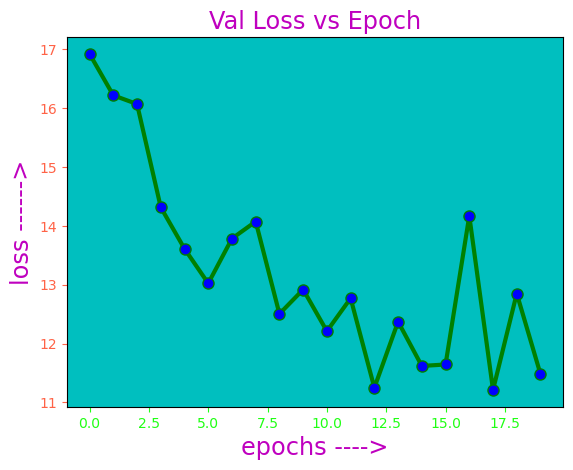

In [22]:
train(dataset,valdataset, model)

In [26]:
# Saving labels to label value as a json
cwd = os.getcwd()
main_dir = os.listdir(os.path.join(cwd,"C:\JITHIN\Projects\AI & ML\Plant Disease Detection\dataset\dataset/train"))
reference = {}
for i,dir in enumerate(main_dir):
    reference[dir]=i
with open('C:\JITHIN\Projects\AI & ML\Plant Disease Detection\labels.json', 'wb') as iw:
    pickle.dump(reference, iw)

In [31]:
# Save the entire model
torch.save(model, "model.pth")
